# Model Training

# Data Reading

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
df = pd.read_csv("df_final.csv")

In [3]:
df.head()

,DATE,p_saving_rate,target,mortgage,permit,population,emratio,income,new_private_hw_under,gdp,home_ow_rate,House_starts,total_emp_cons,labor_percent,monthly_supply,unemployed_rate,MspUS
0,01-01-1987,9.4,63.735,9.2040,1690,241857,61.0,3820.2,1090.0,4722.156,63.9,1774,5007,65.4,6.0,6.6,97900
1,01-02-1987,8.2,64.135,9.0825,1689,242005,61.1,3845.0,1096.0,4722.156,63.9,1784,5038,65.5,6.2,6.6,97900
2,01-03-1987,8.1,64.470,9.0350,1704,242166,61.2,3863.8,1084.0,4722.156,63.9,1726,5039,65.5,6.0,6.6,97900
3,01-04-1987,4.1,64.973,9.8325,1601,242338,61.3,3875.4,1079.0,4806.160,63.9,1614,5053,65.4,6.0,6.3,103400
4,01-05-1987,7.8,65.547,10.5960,1500,242516,61.6,3908.6,1070.0,4806.160,63.9,1628,5080,65.7,6.7,6.3,103400


# Data splitting and Scaling

In [4]:
X = df.drop(columns=['DATE', 'target'], axis=1)
y = df.target

In [5]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training

In [7]:
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5)

lasso_cv_model.fit(X_train, y_train)

lasso_cv_predictions = lasso_cv_model.predict(X_test)

In [8]:
optimal_alpha = lasso_cv_model.alpha_

mse = mean_squared_error(y_test, lasso_cv_predictions)

rmse = np.sqrt(mse)

r2 = r2_score(y_test, lasso_cv_predictions)

print(f"Optimal Alpha: {optimal_alpha:.4f}")
print(F"Mean Squared Error (MSE): {mse:.2f}")
print(f"RMSE: {rmse:2f}")
print(f"R-squared (R2): {r2:.2f}")

Optimal Alpha: 0.0105
Mean Squared Error (MSE): 22.67
RMSE: 4.761756
R-squared (R2): 0.99


# Cross validation

In [9]:
cross_val_scores = cross_val_score(lasso_cv_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R-squared crosses:")
print(cross_val_scores)

Cross-Validation R-squared crosses:
[0.99370309 0.99245816 0.99205821 0.99147036 0.99312816]


In [10]:
mean_r2 = cross_val_scores.mean()
std_r2 = cross_val_scores.std()

print(f"Mean R-squared: {mean_r2:.4f}")
print(f"Standard Deviation of R-squared: {std_r2:.4f}")

Mean R-squared: 0.9926
Standard Deviation of R-squared: 0.0008


In [11]:
print(0.1 * rmse)
print(0.1 * df['target'].mean()) 
# rmse should be less than the 10% of mean of target variable

0.47617563294388665
14.11514874715262


# Most Prominent features and least prominent features

In [12]:
#cpoefficients and corresponding feature names
lasso_coefficients = lasso_cv_model.coef_
feature_names = X.columns

coefficients_df = pd.DataFrame({'Features': feature_names, 'Coefficient': lasso_coefficients})

non_zero_coefficients_df = coefficients_df[coefficients_df['Coefficient'] != 0]
zero_coefficients_df = coefficients_df[coefficients_df['Coefficient'] == 0]

In [13]:
non_zero_coefficients_df

,Features,Coefficient
0,p_saving_rate,-1.441766
1,mortgage,-2.927879
2,permit,1.271435
3,population,-23.163324
4,emratio,-7.821907
6,new_private_hw_under,6.932420
7,gdp,47.242059
8,home_ow_rate,0.561150
9,House_starts,2.315206
10,total_emp_cons,9.087833


In [14]:
zero_coefficients_df

,Features,Coefficient
5,income,-0.0


# Predicted vs Observed

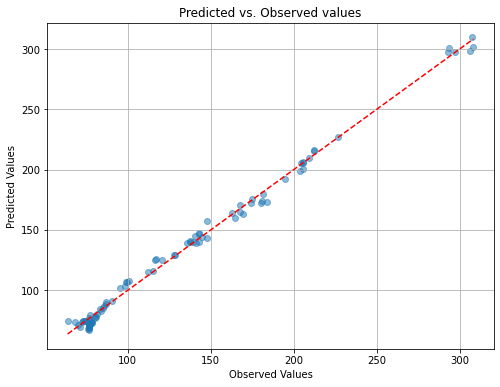

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, lasso_cv_predictions, alpha=0.5)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Observed values")
plt.grid(True)

#Add a diagonal line for refrence (prefectr prediction)
x=np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--')

plt.show()